<a href="https://colab.research.google.com/github/thomasarmstrong98/thirdyearproj/blob/master/altered_lotka_volterra_bimodal_posterior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import pandas as pd
import scipy.stats

# Parameter Estimation for an altered Lotka-Volterra Equations

Following the framework we have preivously developed:

 - ODE model as described below
 - Multivariate Normal Noise Model
 - Normal Priors for our Parameters
 
### ODE Model
 
 \begin{aligned}
 \dot x &=  -x + (\frac{1}{3}(a -0.5)^2 + 2)\,xy \\
 \dot y& =  y - bxy
 \end{aligned}
 
 Has a solution $\boldsymbol{x}(t) = (V(t), R(t))$ at time $t$.

### Noise Model
We will simplify our noise model so that there is independence between the parameters we are trying to infer from. This is done by having a diagonal matrix in our mutlivariate normal distribution, as shown below.

If $\boldsymbol{y_i}$ is an observation of both spacial variabels our system at time $t_i$, then we our noise model is:

$$ \boldsymbol{y_i} \mid \boldsymbol{\theta} \sim N( \boldsymbol{x}(t_i , \boldsymbol{\theta}), \Sigma), \qquad 
\Sigma = \begin{bmatrix}
\sigma_1^2 & 0 \\
0 & \sigma_2^2 
\end{bmatrix}  $$

### Prior for Parameters

We will be performing inference on $\boldsymbol{\theta} = (a, b)$, that is, we assume that we know the value of $c$. As above, we simply the prior so that the parameters are independent apriori (and therefore aposteriori).

$$ \boldsymbol{\theta}\sim N( \boldsymbol{\mu}, \Delta), \qquad 
\Delta = \begin{bmatrix}
\tau_1^2 & 0 \\
0 & \tau_2^2 
\end{bmatrix}  $$


### Inference 
Since we will be using the Metropolis Hastings (MH) algorithm to sample from the posterior, we do not need to calculate the evidence term in Bayes Formula. Our posterior is therefore:

$$ p(\boldsymbol{\theta} \mid \boldsymbol{y}) \propto p(\boldsymbol{\theta}) \: \prod_{i = 1}^{m} p(\boldsymbol{y}_i \mid \boldsymbol{\theta}) $$

For numerical stability, we will be using the log likelihood.

### Construction of Parameters in ODE model.

For this example, I would like to explore how the MH algorithm fares with mutli-modal distributions. To try and create a mutli-modal posterior, I have altered the Lotka-Volterra to depend on a funciton of a parameter, that is:

$$ \dot x = x + g(a)\,xy ,\quad \text{where} \quad g(a)  =\frac{1}{3}(a -0.5)^2 + 2) $$

This is so that we have a two values of $a$ which could give rise to the data due the symmetry of $g(a)$ around $a=\frac{1}{2}$. I believe this should give to a bi-modal likelihood distribution.

In [0]:
def dX_dt (t, x):
    xdot = np.empty((2,))
    xdot[0] = -x[0] + (-0.33*(a -0.5)**2 + 2)*x[0]*x[1]
    xdot[1] = x[1] - b*x[0]*x[1]
    return xdot

In [4]:
a, b = -1.5, 0.8
initial_X = [2, 1]

t = np.linspace(0, 50, 101)
output = integrate.solve_ivp(dX_dt, [0,50], initial_X, t_eval = t, vectorized = False)
print( output["message"])

The solver successfully reached the end of the integration interval.


In [0]:
solution = pd.DataFrame(index = output["t"])
solution["x"] = output["y"][0]
solution["y"] = output["y"][1]

# Now we disrupt the data by adding some zero-centred Gaussain Noise to the solution of our ODE.
scale = 0.05

x_experiment  = [sol + np.random.normal(0, scale) for sol in solution["x"]]
y_experiment  = [sol + np.random.normal(0, scale) for sol in solution["y"]]

In [0]:
sim_df = pd.DataFrame(index = output["t"])
sim_df["x"] = x_experiment
sim_df["y"] = y_experiment

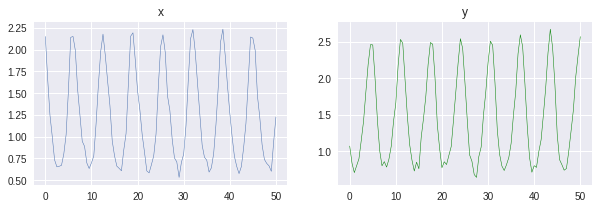

In [7]:
f = plt.figure(figsize=(10,3))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(sim_df["x"], linewidth = 0.5)
ax.set_title("x")
ax2.plot(sim_df["y"], color = 'g', linewidth = 0.5)
ax2.set_title("y")

plt.show()

If we study the nullclines of this system then we can deduce its fixed points.

$$\begin{equation}
  \left.\begin{aligned}
  \dot x&=-x + ((a -0.5)^2 + 2) xy \overset{!}{=} 0\\
  \dot y&=y - b xy \overset{!}{=} 0\\
\end{aligned}\right\} \implies (0,0) \:  \text{and} \: (\frac{1}{b}, \frac{1}{(a -0.5)^2 + 2})\:\text{are fixed points.}
\end{equation}$$


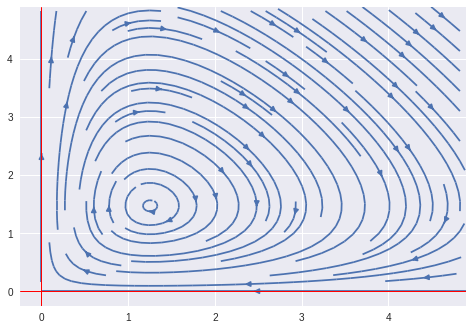

In [8]:
xvalues, yvalues = np.meshgrid(np.arange(0, 5, 0.1), np.arange(0, 5, 0.1))
xdot = -xvalues + (-(0.33)*(a -0.5)**2 + 2)*xvalues*yvalues
ydot = yvalues - b*xvalues*yvalues
plt.streamplot(xvalues, yvalues, xdot, ydot)
plt.axvline(x = 0, color = 'r', lw=1, label='x-nullcline')
plt.axhline(y = 0, color = 'r', lw=1, label='y-nullcline')
plt.show()

Here 

## Priors for our Parameters $a$ and $b$ and Noise Model.

In [0]:
#Priors

#theta = (a, b)

mu = np.array([0.15, 0.25])

Delta = np.array([[0.5, 0],
                  [0, 0.5]])

def prior(theta):
    return scipy.stats.multivariate_normal.pdf(theta, mu, Delta)

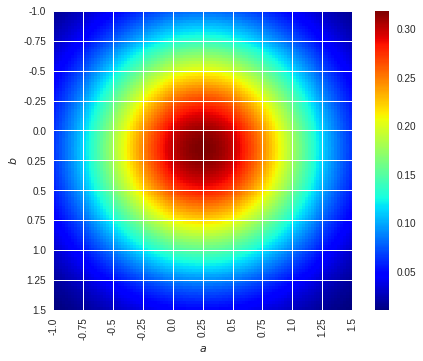

In [298]:
a_grid = np.linspace(-1, 1.5, 101)
b_grid = np.linspace(-1, 1.5, 101)

a_b_grid = np.zeros([len(a_grid), len(b_grid)])

for i in range(len(a_grid)):
    for j in range(len(b_grid)):
        a_b_grid[i, j] = prior([a_grid[i], b_grid[j]])
        
a_axis = []
for i in range(11):
    a_axis.append(a_grid[i*10])
    
b_axis = []
for i in range(11):
    b_axis.append(b_grid[i*10])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(a_axis)
plt.xticks(range(len(a_axis)), rotation = 90)
ax.set_yticklabels(b_axis)
plt.yticks(range(len(b_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.imshow(a_b_grid, cmap = 'jet')
plt.colorbar(orientation='vertical')
plt.show()

In [0]:
#Likelihood / Noise Model
# - requires the observed data, the time of the observed data, and the solution to our ODE at that time.

Sigma = np.array([[0.1, 0],
                  [0, 0.1]])

def diff_eqn_solution(theta):
    t = np.linspace(0, 50, 101)
    a = theta[0]
    b = theta[1]
    output = integrate.solve_ivp(dX_dt, [0,50], initial_X, t_eval = t, vectorized = False)
    x = output["y"][0]
    y = output["y"][1]
    proposed_df = pd.DataFrame(index = t)
    proposed_df["x"] = x
    proposed_df["y"] = y
    return proposed_df

def log_likelihood(theta, sim_df):
    sum = 0
    proposed_df = diff_eqn_solution(theta)
    for index, obs in sim_df.iterrows():
        sum = sum + np.log(scipy.stats.multivariate_normal.pdf(sim_df.loc[index], proposed_df.loc[index], Sigma))       
    return sum
  
def posterior(theta, sim_df):
    return np.exp(log_likelihood(theta, sim_df))*prior(theta)

## Metropolis Hastings Algorithm

In [0]:
#Define our proposal distribution, q_dist. In this case we will choose a Gaussian, simplifing our posterior comparison ratio.

q_Cov_Matrix = np.array([[0.2, 0],
                         [0, 0.2]])


def q_dist(theta, q_Cov_Matrix):
    return scipy.stats.multivariate_normal.rvs(theta, q_Cov_Matrix)

In [0]:
def mh_algorithm(x_0, no_of_cycles, sim_df):
    #Altered MH Algorithm from previous MH coded in Logisitic example 
    import time
    time_hist = []
    #x_0 is the tuple x_0= (lam_0, k_0)
    hist_of_moves = pd.DataFrame(columns = ["a", "b"])
    hist_of_moves = hist_of_moves.append(pd.DataFrame([[x_0[0],x_0[1]]], columns = ["a", "b"]))
    x_t = x_0
    for i in range(no_of_cycles):
        start = time.time()
        #generate a new move from x_0
        y_t = q_dist(x_t, q_Cov_Matrix)
        p_x = posterior(x_t, sim_df)
        p_y = posterior(y_t, sim_df)
        comparison  = p_y/p_x
        alpha = min(comparison, 1)
        rand_number = np.random.uniform(0,1)
        if rand_number > 1-alpha:
            x_new = y_t
        else:
            x_new = x_t
        hist_of_moves = hist_of_moves.append(pd.DataFrame([[x_new[0], x_new[1]]], columns = ["a", "b"]))
        x_t = x_new
        end = time.time()
        time_hist.append(end - start)
    print("Completed: " + str(no_of_cycles) + " cycles")
    hist_of_moves = hist_of_moves.reset_index()
    hist_of_moves = hist_of_moves.drop(["index"], axis=1)
    return hist_of_moves , time_hist

In [307]:
import time
start = time.time()
trace, time_hist = mh_algorithm([-1,1], 5000, sim_df)
end = time.time()
print("MH algorithm took: " + str(end - start) + "seconds to complete")

Completed: 5000 cycles
MH algorithm took: 556.3973252773285seconds to complete


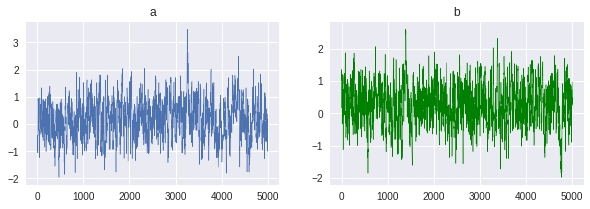

In [308]:
trace['a'] = pd.to_numeric(trace['a'])
trace['b'] = pd.to_numeric(trace['b'])

f = plt.figure(figsize=(10,3))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(trace["a"], linewidth = 0.5)
ax.set_title("a")
ax2.plot(trace["b"], color = 'g', linewidth = 0.5)
ax2.set_title("b")

plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


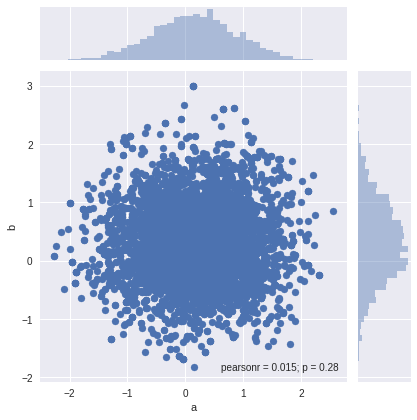

In [254]:
import seaborn as sns
sns.jointplot(x=trace["a"], y=trace["b"], kind='scatter')
plt.show()

In [193]:
trace['b'].dtype.kind

'O'

In [0]:
trace['b'] = pd.to_numeric(trace['b'])

In [0]:
df_1 = diff_eqn_solution((-1.5, 0.8))

In [0]:
df_2 = diff_eqn_solution((2.5, 0.8))

In [305]:
df_1.head()

,x,y
0.0,2.000000,1.000000
0.5,1.637083,0.795398
1.0,1.283712,0.732475
1.5,1.002654,0.766310
2.0,0.803080,0.882757


In [306]:
df_2.head()

,x,y
0.0,2.000000,1.000000
0.5,1.637083,0.795398
1.0,1.283712,0.732475
1.5,1.002654,0.766310
2.0,0.803080,0.882757
